# Fitting a line with TF
This is a TF implementation of the "fitting a line to data" exercise from Hogg's paper.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

<ErrorbarContainer object of 3 artists>

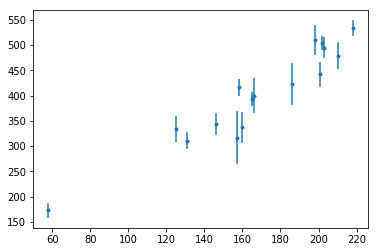

In [2]:
_, x_all, y_all, sigy_all, _, _ = np.genfromtxt("data.txt", unpack=True, 
                                                delimiter='&', 
                                                skip_header=1)
x    = x_all[4:]
y    = y_all[4:]
sigy = sigy_all[4:] #For now we skip the first 4 points
plt.errorbar(x, y, sigy, ls='', marker='.')

In [3]:
#Define a PGM
#Placeholder for the data
X = tf.placeholder(dtype=tf.float32)
Y = tf.placeholder(dtype=tf.float32)
SIGY = tf.placeholder(dtype=tf.float32)

#Parameter guesses
m = tf.Variable(initial_value=np.random.normal(loc=1, scale=1),
                  dtype=tf.float32)
b = tf.Variable(initial_value=np.random.normal(loc=1, scale=1),
                  dtype=tf.float32)

In [4]:
#Linear model
model = tf.add(tf.multiply(X, m), b)

In [5]:
LEARNING_RATE = 0.01
MAX_ITER = 1000
TOL_PARAM, TOL_CHI2 = 1e-3, 1e-3

#Chi2 minimization
#chi2 = tf.reduce_sum(tf.divide(tf.pow(Y-model, 2), tf.pow(SIGY,2)))
chi2 = tf.reduce_sum(tf.pow(Y-model, 2)/SIGY**2)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
train_op = optimizer.minimize(chi2)

In [6]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    i = 1
    obs_m, obs_b = sess.run(fetches=[[m], [b]])
    obs_chi2 = sess.run(fetches=[chi2], feed_dict={X: x, Y:y, SIGY: sigy})
    
    while True:
        sess.run(fetches=train_op, feed_dict={X: x, Y:y, SIGY: sigy})
        
        #Update parameters
        new_m, new_b = sess.run(fetches=[m, b])
        diff_norm = np.linalg.norm(np.subtract([new_m, new_b],
                                              [obs_m[-1], obs_b[-1]]))
        #Update chi2
        new_chi2 = sess.run(fetches=chi2, feed_dict={X: x, Y:y, SIGY: sigy})
        chi2_diff = np.abs(new_chi2 - obs_chi2[-1])
        
        obs_m.append(new_m)
        obs_b.append(new_b)
        obs_chi2.append(new_chi2)
        
        if diff_norm < TOL_PARAM:
            print('Parameter convergence in {} iterations.'.format(i))
            break
        if chi2_diff < TOL_CHI2:
            print('Chi2 convergence in {} iterations.'.format(i))
            break
        if i >= MAX_ITER:
            print('Max iterations reached without convergence.')
            break
        i += 1

Chi2 convergence in 86 iterations.


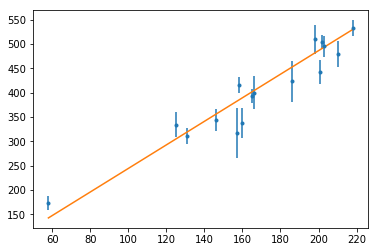

In [7]:
#Best model
ind = np.argmin(obs_chi2)
m_best = obs_m[ind]
b_best = obs_b[ind]
plt.errorbar(x, y, sigy, ls='', marker='.')
xp = np.linspace(min(x),max(x))
yp = m_best*xp + b_best
plt.plot(xp, yp)